In [30]:
#Importing EDA related functions
import numpy as np
import os
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime 
from time import time
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
from statsmodels.tsa.arima.model import ARIMA
from time import time
#import matplotlib.pylab as plt #for visualization

#Importing Time series Related Functions

#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import accuracy_score
#from sklearn.ensemble import IsolationForest

#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.tsa.seasonal import seasonal_decompose

#Taking datetime index as reading csv
def parser(x):  
    return datetime.strptime(x,'%m/%d/%y')  
dataset = pd.read_csv('27IndiaConfirmed.csv',header=0, delimiter=',',index_col=0, parse_dates=[0], date_parser=parser)  


In [2]:
dataset = pd.read_csv('IndiaConfirmed12Sept21.csv',header=0, delimiter=',')

In [3]:
dataset.head()

,Date,ConfirmedCases
0,01/22/20,0
1,01/23/20,0
2,01/24/20,0
3,01/25/20,0
4,01/26/20,0


In [7]:
print(dataset.shape)

(599, 2)


In [4]:
dataset["DailyCases"]=0
# print(dataset.head(),"\n")
# print(dataset.tail(5),"\n")
# print(dataset.info(),"\n")
# print(dataset.dtypes,"\n")

In [5]:
for i in range(2,len(dataset)):
    dataset.iloc[i,2]=dataset.iloc[i,1]-dataset.iloc[i-1,1]
#Here Date column is a string(i.e. object) we need to convert it to datetime object
dataset['Date']=pd.to_datetime(dataset['Date'])
# dataset.set_index('Date')# Used to set date column as index column.Didn't work first since inplace was false by default
dataset.set_index('Date',inplace=True)


In [6]:
print(dataset.info())
print("\n\n",dataset.head(2))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 599 entries, 2020-01-22 to 2021-09-11
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ConfirmedCases  599 non-null    int64
 1   DailyCases      599 non-null    int64
dtypes: int64(2)
memory usage: 14.0 KB
None


             ConfirmedCases  DailyCases
Date                                  
2020-01-22               0           0
2020-01-23               0           0


 d3=d2.copy(deep=True)  
 d3 = d3.set_index(pd.DatetimeIndex(d3['Date']))  
 d3.set_index(['Date'])  
 df.set_index(['Datetime'])  

Converting string object to specific datetime format(output wala) 
 * df['Dates'] = pd.to_datetime(df['Dates'], format='%y%m%d')

dataset=dataset.drop(['Date'],axis=1)

plt.style.use('seaborn')
plt.figure(figsize=(12,5))
#dataset.plot()
plt.plot(dataset)
plt.show()

plt.style.use('seaborn')
plt.figure(figsize=(12,5))
plt.plot(dataset["DailyCases"])
plt.show()

## Splitting Daily Cases dataset into train and test 

In [7]:
from sklearn.model_selection import train_test_split as tts
daily=dataset.filter(['DailyCases'],axis=1)
daily = daily.asfreq(pd.infer_freq(daily.index))

train_size=0.8
test_size=0.2
daily_train,daily_test = tts(daily,test_size = test_size, random_state=0, shuffle=False)
 

In [8]:
print("\nDaily",daily.head(2))
print("\nTrain",daily_train.head(2))
print("\nTest",daily_test.head(2))
print("\nTrain Count : ",daily_train.count(),"\nTest Count : ",daily_test.count())
# daily_train.plot()
# daily_test.plot()


Daily             DailyCases
Date                  
2020-01-22           0
2020-01-23           0

Train             DailyCases
Date                  
2020-01-22           0
2020-01-23           0

Test             DailyCases
Date                  
2021-05-15      311170
2021-05-16      281386

Train Count :  DailyCases    479
dtype: int64 
Test Count :  DailyCases    120
dtype: int64


In [19]:
print("Training Dataset End ", daily_train.index[-1])
print("Testing Dataset Start ", daily_test.index[0])

Training Dataset End  2021-05-14 00:00:00
Testing Dataset Start  2021-05-15 00:00:00


## Plotting Rolling Mean and Standard Deviation of Dataset - Visual Test for Checking  Stationarity of dataset

In [9]:
def check_mean_std(ts, name):

    rolmean = ts.rolling(window=15).mean()
    rolstd = ts.rolling(window=15).std()
    plt.figure(figsize=(10,6))   
    print(name)
    
    plt.style.use('seaborn')
    plt.figure(figsize=(12,8))
    plt.plot(ts, color='red',label='Original')
    plt.plot(rolmean, color='black', label='Rolling Mean')
    plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d, %b, %Y')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.tight_layout()
    plt.xlabel("Date")
    plt.ylabel("Daily Cases")
    plt.title('COVID-19 Daily Cases '+name+' Rolling Mean & Standard Deviation(India)')
    plt.legend()
    plt.show()



 Original Dataset


<Figure size 720x432 with 0 Axes>

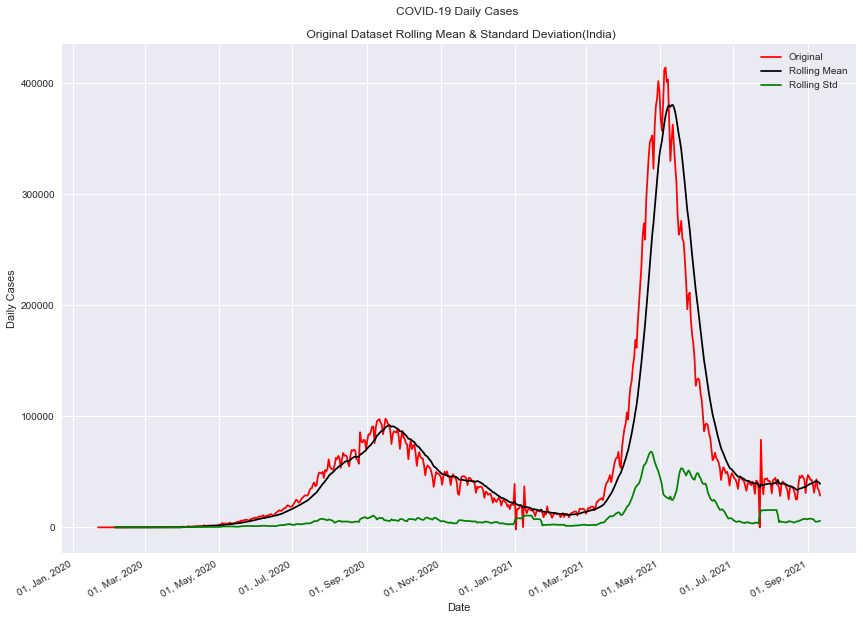

In [79]:
check_mean_std(dataset['DailyCases'],'\n\n Original Dataset')

#### The moving average is not constant but standard deviation seems to be constant.
#### The dataset to be stationary must follow 3 constraints:-
#### 1. Rolling Mean must be constant  
#### 2. Standard Deviation must be constant 
#### 3. Seasonality shouldn't be there
#### 1 and 3 are not satisfied. Hence dataset is not stationary

## Performing ADF Test for checking stationarity of dataset

In [10]:
from statsmodels.tsa.stattools import adfuller
def check_adfuller(att):

    print('Results of Augmented Dickey Fuller Test:')
    print("\nInformation: For a stationary time series Test statistic is less than critical values.The p value[ranged between 0 to 1] <=0.05 for stationary time series\n")
    dftest = adfuller(att, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

In [27]:
check_adfuller(dataset['DailyCases'])

Results of Augmented Dickey Fuller Test:

Information: For a stationary time series Test statistic is less than critical values.The p value[ranged between 0 to 1] <=0.05 for stationary time series

Test Statistic                  -3.368036
p-value                          0.012098
#Lags Used                      16.000000
Number of Observations Used    582.000000
Critical Value (1%)             -3.441636
Critical Value (5%)             -2.866519
Critical Value (10%)            -2.569422
dtype: float64


###  The p-value is very less, and the Test Statistic is less than Critical Values - So according to ADF Test the time series is somewhat stationary on the whole.

## Plotting AutoCorrelationFunction(ACF) and Partial AutoCorrelation Function(PACF) Graphs
RitMat

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


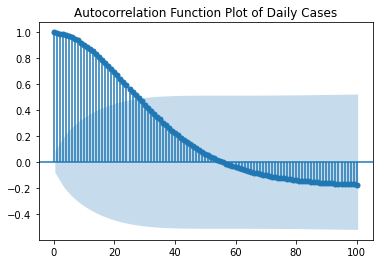

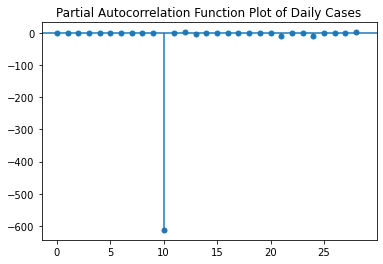

In [12]:
acf_plot = plot_acf(daily.DailyCases,title="Autocorrelation Function Plot of Daily Cases",lags=100)

# plt.plot(daily.DailyCases)

pacf_plot = plot_pacf(daily.DailyCases,title="Partial Autocorrelation Function Plot of Daily Cases")

### Old :Based on PACF Graph it looks like the lags 1,2,7,8,9,11,13,19 are good places to start for Auto Regressive model.
### 6 June : Based on PACF Graph it looks like the lags 9,11,13,25 are good places to start for Auto Regressive model.
### 12 September : Only PACF value is 10

### The auto correlation function(ACF) graph is decaying over time, which suggest an auto regressive process inherently. If it would have shut off immediately after some lags, it would have been close to a moving average model

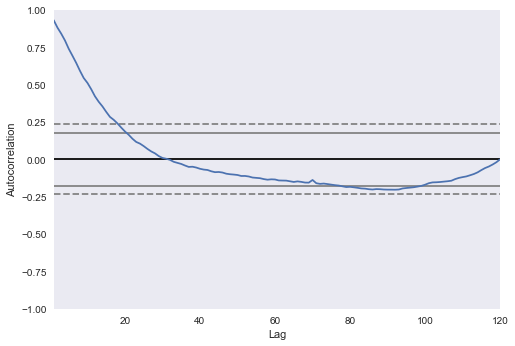

<Figure size 1440x1080 with 0 Axes>

In [44]:
from pandas.plotting import autocorrelation_plot  
x = autocorrelation_plot(daily_test)
   
# plt.style.use('seaborn')
plt.figure(figsize=(20,15))
# ploting the Curve
# plt.plot(x)
plt.show()

Lag Value for  
    daily : 50  
    train : 100  
    test : 30
    
Lag Value for  
    daily : 50  
    train : 50
    test : 20
    

In [13]:
from statsmodels.tsa.stattools import acf, pacf
def acf_pacf_plots(dataset):
#     ts_diff = dataset - dataset.shift()
#     ts_diff.dropna(inplace=True)
    acf_result = acf(dataset,nlags=60)
    pacf_result = pacf(dataset,nlags=10, method='ols')
    
    # ACF
    plt.figure(figsize=(22,10))
    plt.style.use('seaborn')
    plt.subplot(121) 
    plt.plot(acf_result)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.xlabel("Lags")
    plt.ylabel("Autocorrelation")
    plt.title('Autocorrelation Function')
    
#     PACF
    plt.subplot(122)
    plt.style.use('seaborn')
    plt.plot(pacf_result)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.xlabel("Lags")
    plt.ylabel("Partial Autocorrelation")
    plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


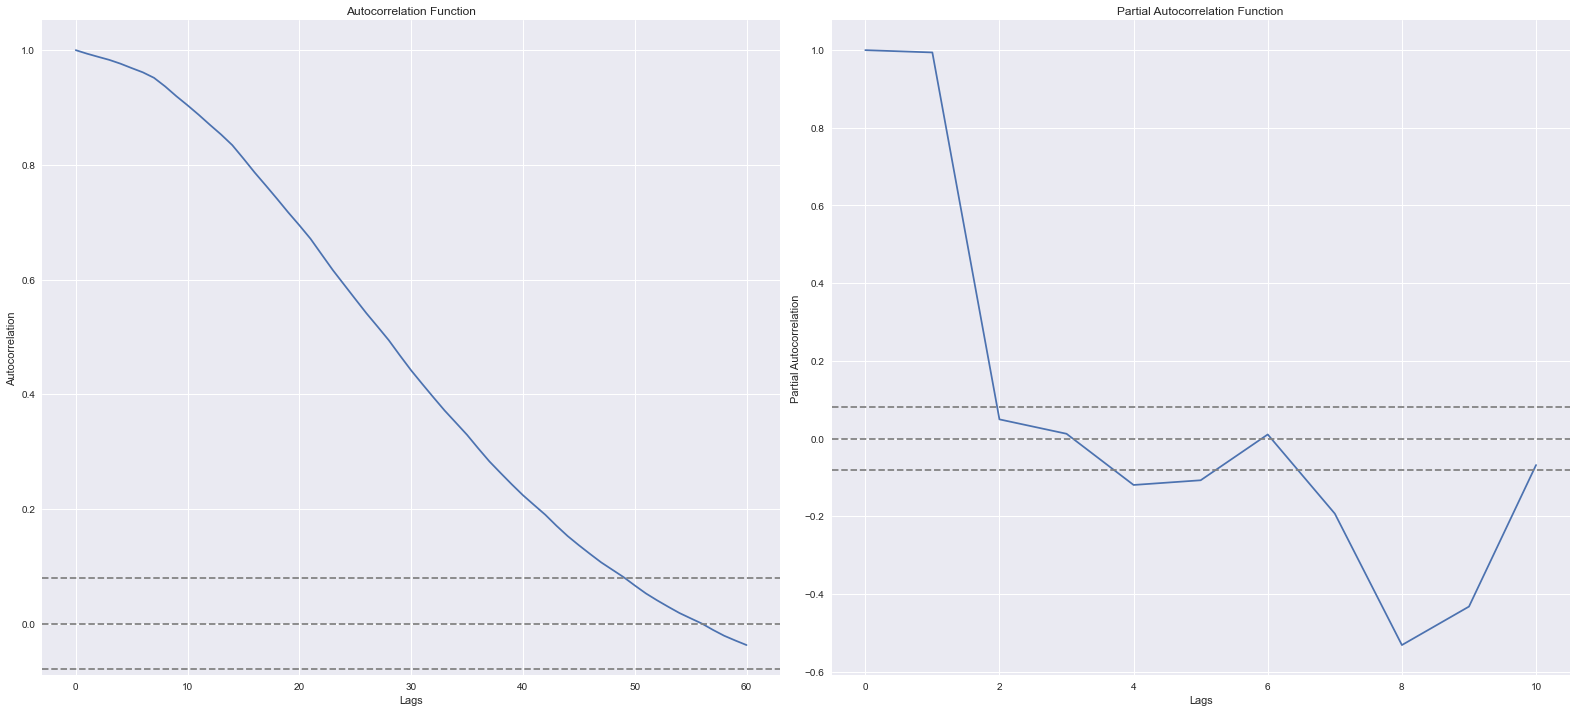

In [46]:
acf_pacf_plots(daily)

Lags for pacf = 2
Lag for acf = 50

In [ ]:
# pip install --user pmdarima

In [ ]:
# Import the library 
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(daily_train, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 0, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

#Worth Knowing : How to index dataframe whose index is datetime
from datetime import timedelta
a = datetime(2021,1,15)
b = datetime(2021,2,15)

dummy = daily[:a]
dummy2 = daily[a+timedelta(days=1):b]
#It Works!

### Auto Regressive Only Model

In [47]:
from statsmodels.tsa.arima.model import ARIMA
from time import time
#stas..tsa.arima_model > Depreceated
#ARMA Model also deprecated. Hence using ARIMA

### Creating the AR Model  
>Only using AR parameter i.e. p = 11 retreived from PACF Plot(direct lag autocorrelation)

In [49]:
ar_model=ARIMA(daily_train.DailyCases, order=(25,0,0))
#Warnings dissappeared after applying inferred frequency function

Fitting the created model to our dataset. We actually apply the model to the data now


In [50]:
start =time()
ar_model_fit=ar_model.fit()
end = time()
print("Model Fitting Time : ", end-start," s")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Fitting Time :  38.62418794631958  s


### Un- Transformed Series 

In [51]:
#Summary of the model
print(ar_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             DailyCases   No. Observations:                  479
Model:                ARIMA(25, 0, 0)   Log Likelihood               -4777.295
Date:                Sun, 12 Sep 2021   AIC                           9608.590
Time:                        15:59:56   BIC                           9721.226
Sample:                    01-22-2020   HQIC                          9652.868
                         - 05-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.088e+04   7.03e-08   7.24e+11      0.000    5.09e+04    5.09e+04
ar.L1          0.5922      0.029     20.579      0.000       0.536       0.649
ar.L2          0.3427      0.040      8.589      0.0

## First Differenced Series

In [14]:
daily.shape

(599, 1)

In [15]:
daily_first_difference = daily.DailyCases.diff()

print(daily_first_difference.head(2))

daily_first_difference[0]=0.0

print(daily_first_difference.shape)
print(type(daily_first_difference))

Date
2020-01-22    NaN
2020-01-23    0.0
Freq: D, Name: DailyCases, dtype: float64
(599,)
<class 'pandas.core.series.Series'>


In [16]:
fd_daily=pd.DataFrame(daily_first_difference)

In [17]:
fd_daily.index[0]

Timestamp('2020-01-22 00:00:00', freq='D')

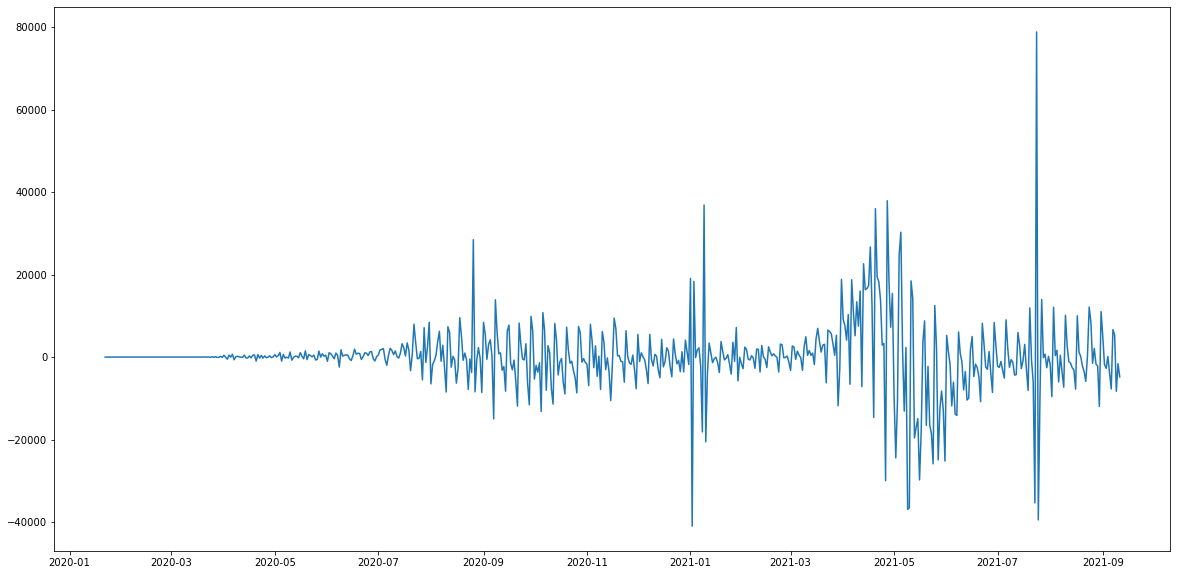

In [18]:
plt.figure(figsize=(20,10))
plt.plot(daily_first_difference)



Daily Cases First Differenced


<Figure size 720x432 with 0 Axes>

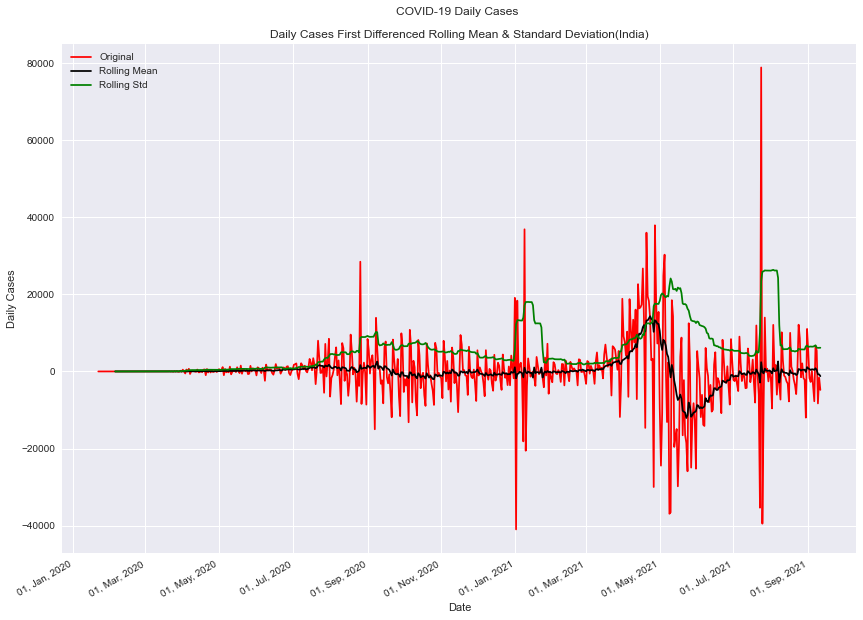

In [19]:
check_mean_std(daily_first_difference,'\n\nDaily Cases First Differenced')

In [83]:
check_adfuller(daily_first_difference)

Results of Augmented Dickey Fuller Test:

Information: For a stationary time series Test statistic is less than critical values.The p value[ranged between 0 to 1] <=0.05 for stationary time series

Test Statistic                  -4.701503
p-value                          0.000084
#Lags Used                      19.000000
Number of Observations Used    578.000000
Critical Value (1%)             -3.441714
Critical Value (5%)             -2.866553
Critical Value (10%)            -2.569440
dtype: float64


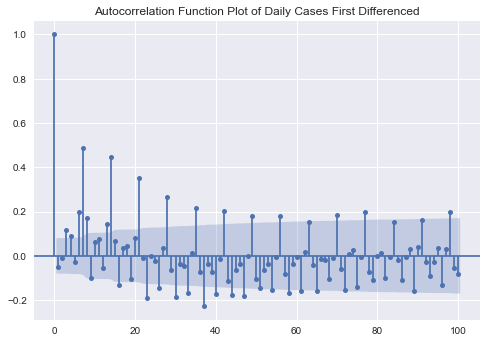

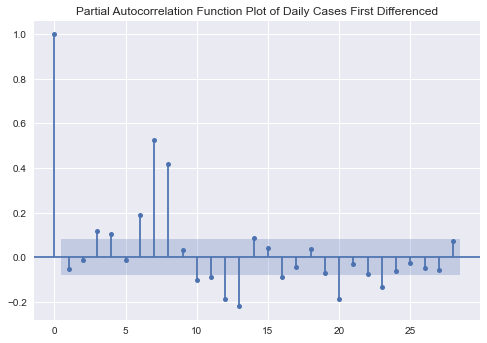

In [20]:
acf_plot = plot_acf(daily_first_difference,title="Autocorrelation Function Plot of Daily Cases First Differenced",lags=100)

# plt.plot(daily.DailyCases)

pacf_plot = plot_pacf(daily_first_difference,title="Partial Autocorrelation Function Plot of Daily Cases First Differenced")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


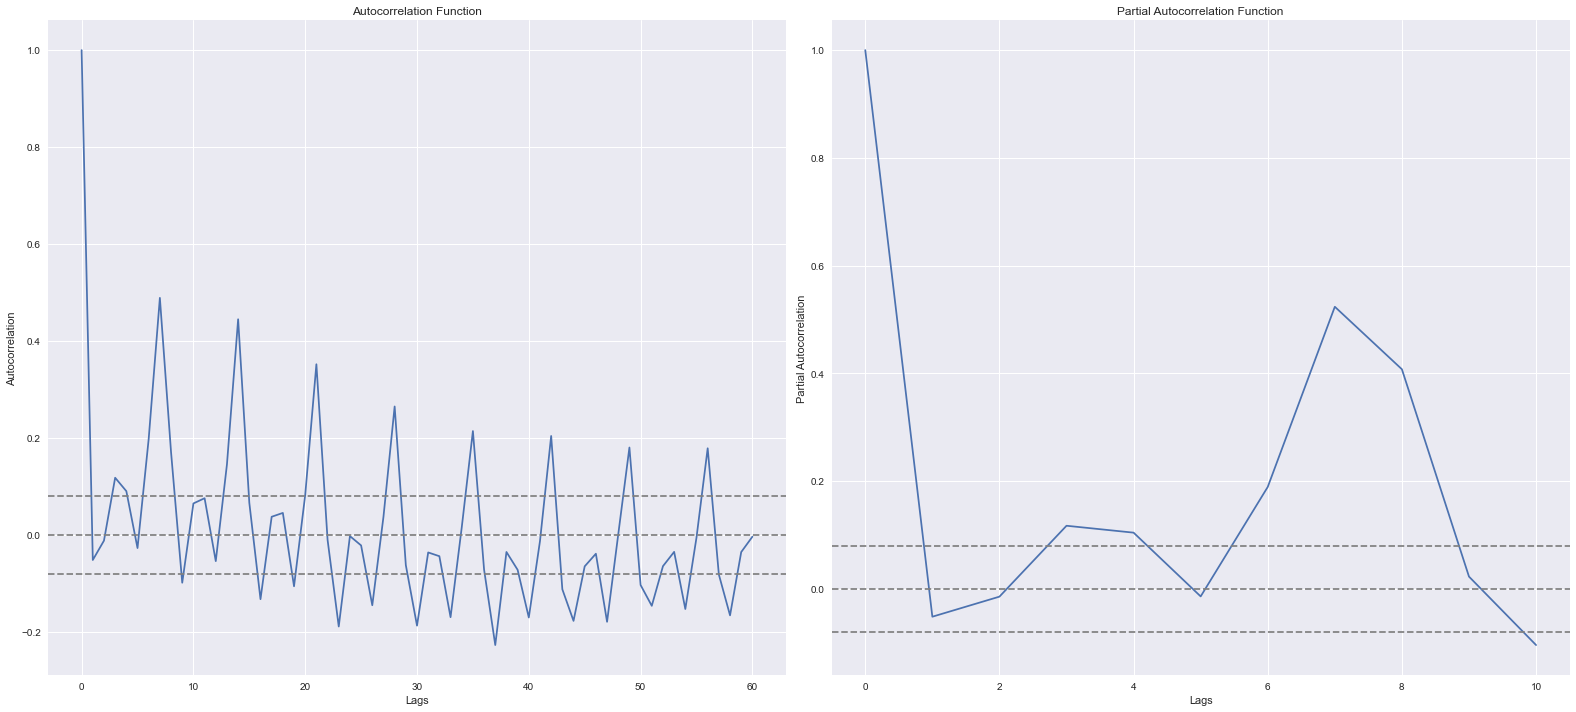

In [86]:
acf_pacf_plots(daily_first_difference)

#### PACF Plot : Lag values till 8 can be taken into account
#### ACF Plot : Lag values till 10 can be taken into account

### Splitting Daily First Differenced Cases dataset into train and test 

In [21]:
type(fd_daily)

pandas.core.frame.DataFrame

In [22]:
daily_first_difference

Date
2020-01-22       0.0
2020-01-23       0.0
2020-01-24       0.0
2020-01-25       0.0
2020-01-26       0.0
               ...  
2021-09-07    6653.0
2021-09-08    5388.0
2021-09-09   -8290.0
2021-09-10   -1597.0
2021-09-11   -4785.0
Freq: D, Name: DailyCases, Length: 599, dtype: float64

In [25]:
from sklearn.model_selection import train_test_split as tts
# daily=dataset.filter(['DailyCases'],axis=1)
# daily = daily.asfreq(pd.infer_freq(daily.index))

train_size=0.8
test_size=0.2
fd_train_daily,fd_test_daily = tts(fd_daily,test_size = test_size, random_state=0, shuffle=False)
 

In [26]:
fd_train_daily.shape

(479, 1)

In [27]:
fd_test_daily.index[0]

Timestamp('2021-05-15 00:00:00', freq='D')

In [28]:
fd_train_daily.index[-1]

Timestamp('2021-05-14 00:00:00', freq='D')

### AR Only

In [85]:
p=5
d=0
q=0
fd_ar_model=ARIMA(fd_train_daily, order=(p,d,q))
#Warnings dissappeared after applying inferred frequency function

# Fitting the created model to our dataset. We actually apply the model to the data now


start =time()
fd_ar_model_fit=fd_ar_model.fit()
end = time()
print("Model Fitting Time : ", end-start," s")

#Summary of the model
print(fd_ar_model_fit.summary())

pred_start_date=fd_test_daily.index[0]
pred_end_date=fd_test_daily.index[-1]


print(pred_start_date)
print(pred_end_date)

fd_predictions_daily = fd_ar_model_fit.predict(start=pred_start_date, end=pred_end_date)

print(type(fd_predictions_daily))

fd_test_daily_s=fd_test_daily.iloc[:,0]

print(type(fd_test_daily_s))

fd_residuals=fd_test_daily_s-fd_predictions_daily

Model Fitting Time :  0.07978606224060059  s
                               SARIMAX Results                                
Dep. Variable:             DailyCases   No. Observations:                  479
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -4944.003
Date:                Sun, 12 Sep 2021   AIC                           9902.006
Time:                        18:55:40   BIC                           9931.208
Sample:                    01-22-2020   HQIC                          9913.486
                         - 05-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        680.7891    442.849      1.537      0.124    -187.180    1548.758
ar.L1          0.0150      0.019      0.791      0.429      -0.022       0.052
ar.L2  

In [96]:
def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value, df_diff].cumsum().astype('float64')
    return series_inverted

In [86]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae


fd_mean_abs_error=mae(fd_test_daily_s,fd_predictions_daily)
order="Order = ({},{},{})".format(p,d,q)
print(order)
print("Mean Absolute Error = ",fd_mean_abs_error)

fd_mean_sqr_error=mse(fd_test_daily_s,fd_predictions_daily)#Mean Square error
print("Mean Square Error = ",fd_mean_sqr_error)



fd_bias=fd_residuals.sum()*1.0/len(fd_test_daily_s)#Bias. Net positive or negative error
print("Bias = ",fd_bias)
print("Root Mean Square Error = ",np.sqrt(fd_mean_sqr_error))#root mean square error

Order = (5,0,0)
Mean Absolute Error =  7559.595697317023
Mean Square Error =  150030485.62897876
Bias =  -3156.0459920057533
Root Mean Square Error =  12248.693221277883


In [90]:
def errorplot(error_residuals,description,order):
    plt.style.use('seaborn')
    plt.figure(figsize=(12,8))
    plt.plot(error_residuals, color='red',label='Original')
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d, %b, %Y')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.tight_layout()
    plt.xlabel("Date")
    plt.ylabel("Error Residual")
    name='COVID-19 Daily Cases(India) Error Residuals '+description+' '+order
    plt.title(name)
    plt.legend()
    plt.savefig(fname='Results\\'+name+'.png', dpi=300, bbox_inches='tight')
    plt.show()

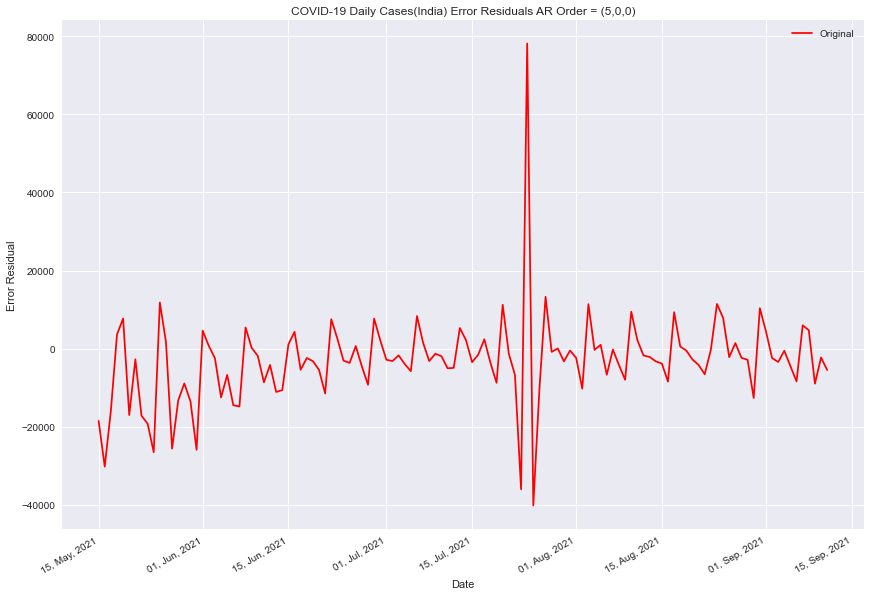

In [91]:
errorplot(fd_residuals,'AR',order)

In [94]:
def vsplot(test,pred,description,order):
    plt.style.use('seaborn')
    plt.figure(figsize=(12,8))
    plt.plot(fd_test_daily_s,color='red',label='Test Data')
    plt.plot(fd_predictions_daily,color='blue',label='Predicted Data')
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d, %b, %Y')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.tight_layout()
    plt.xlabel("Date")
    plt.ylabel("1st Difference")
    name='COVID-19 Daily Cases Prediction(India) AR '+description+' '+order
    plt.title(name)
    plt.legend()
    plt.savefig(fname='Results\\'+name+'.png', dpi=300, bbox_inches='tight')
    plt.show()

## Second Differenced Series

In [71]:
daily_second_difference = daily.DailyCases.diff().diff()[2:]

In [72]:
daily_second_difference.head()

Date
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
Freq: D, Name: DailyCases, dtype: float64

In [73]:
print(daily_second_difference.shape)
print(type(daily_second_difference))

(597,)
<class 'pandas.core.series.Series'>




 Second Differenced


<Figure size 720x432 with 0 Axes>

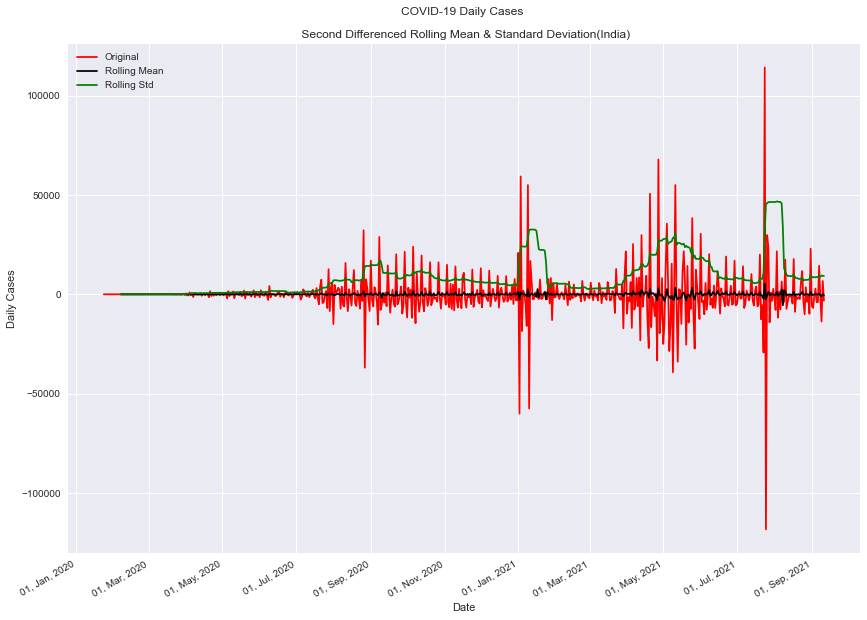

In [80]:
check_mean_std(daily_second_difference,'\n\n Second Differenced')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


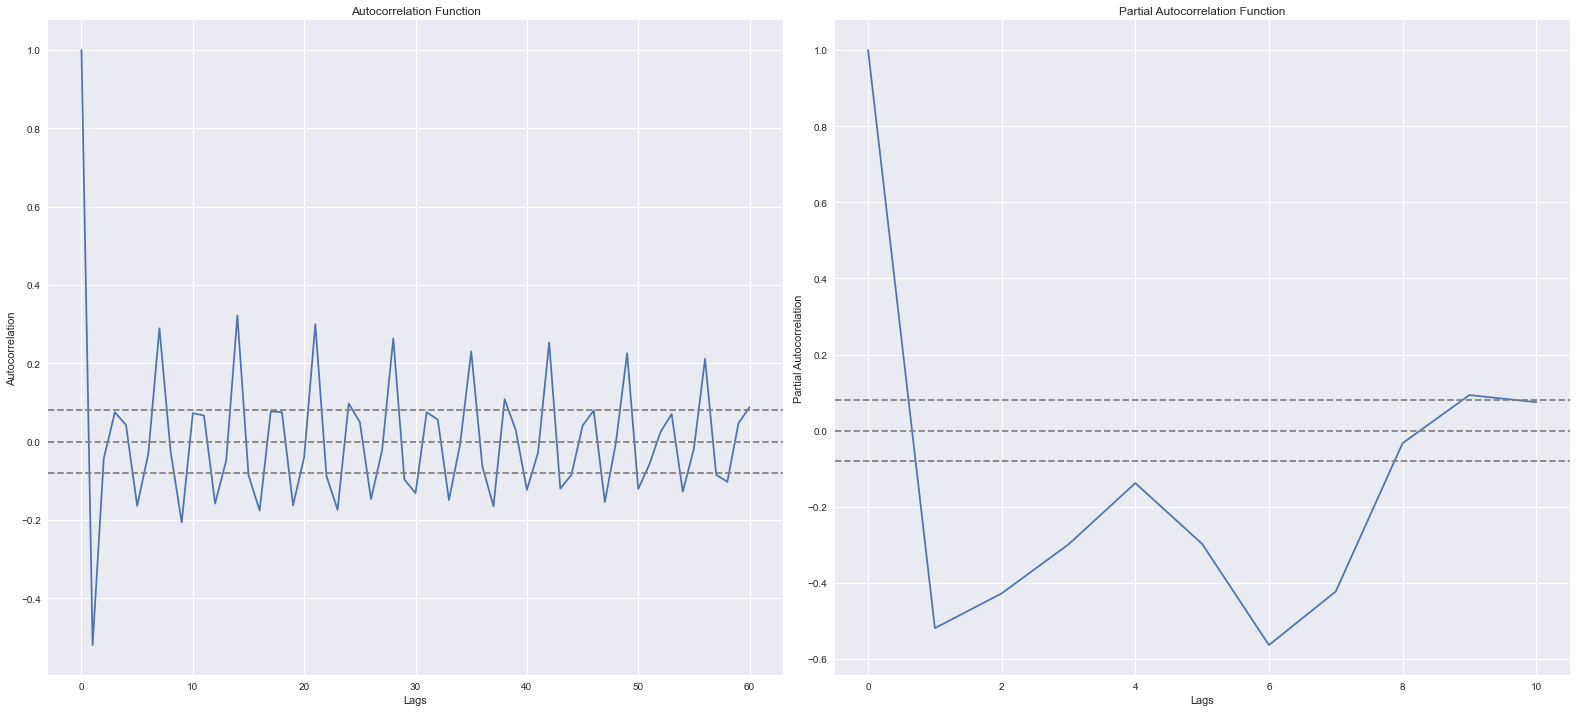

In [82]:
acf_pacf_plots(daily_second_difference)

### ARIMA(11,0,0) : Lags : 1,2,3,6,7,9,11 : For which p value is 0.00

In [ ]:
#get prediction start and end dates
arPredStart = daily_test.index[0]
arPredEnd = daily_test.index[-1]

In [ ]:
#Get the predictions and residuals
ar_pred = ar_model_fit.predict(start=arPredStart,end=arPredEnd)
ar_residuals = daily_test - ar_pred

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(ar_pred,color='b')
plt.plot(daily_train,color='r')
plt.plot(daily_test,color='g')
# plt.title("Residuals from AR Model ",fontsize=20)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)

In [ ]:
ar_pred.plot()
daily_test.plot()

# ------KEEP MOVING FORWARD!!-------